# Area Detector with custom HDF5 File Name

Demonstrate the setup of an [EPICS area detector](https://areadetector.github.io/master/index.html) to acquire an image with [bluesky](https://blueskyproject.io/) and write it to an [HDF5](https://www.hdfgroup.org/solutions/hdf5) file.  Override the default ophyd naming process (which uses random [UUIDs](https://docs.python.org/3/library/uuid.html#uuid.uuid4)) for image files.  Instead, let the user control the image file name using the features of the EPICS Area Detector HDF5 plugin.  Show the image using the [databroker](https://blueskyproject.io/databroker).

**Contents**

- [EPICS Area Detector IOC](#EPICS-Area-Detector-IOC) is pre-built
- [ophyd](#ophyd) to describe the hardware
- [bluesky](#bluesky) for the measurement
- [databroker](#databroker) to view the image
- [punx](#punx) (not part of Bluesky) to look at the HDF5 file

## EPICS Area Detector IOC

This example uses a prebuilt [ADSimDetector](https://areadetector.github.io/master/ADSimDetector/simDetector.html) driver.  Prepare as in [Example with default file names](de_0_adsim_hdf5_basic.ipynb#Recapitulation).  Refer to that document for explanations.

## ophyd

The steps of the basic example are combined together here.  Refer to that document for explanations.  As is customary, the imports come first, then the constants, and classes.

In [1]:
from apstools.devices import AD_EpicsFileNameHDF5Plugin
from apstools.devices import AD_full_file_name_local
from apstools.devices import ensure_AD_plugin_primed
from apstools.devices import CamMixin_V34 as CamMixin
from apstools.devices import SingleTrigger_V34 as SingleTrigger
from ophyd.areadetector import ADComponent
from ophyd.areadetector import DetectorBase
from ophyd.areadetector import SimDetectorCam
from ophyd.areadetector.plugins import ImagePlugin_V34 as ImagePlugin
import apstools
import bluesky
import bluesky.plans as bp
import bluesky.plan_stubs as bps
import databroker
import hdf5plugin
import pathlib

IOC = "ad:"
IMAGE_DIR = "adsimdet/%Y/%m/%d"
AD_IOC_MOUNT_PATH = pathlib.Path("/tmp")
BLUESKY_MOUNT_PATH = pathlib.Path("/tmp/docker_ioc/iocad/tmp")

# MUST end with a `/`, pathlib will NOT provide it
WRITE_PATH_TEMPLATE = f"{AD_IOC_MOUNT_PATH / IMAGE_DIR}/"
READ_PATH_TEMPLATE = f"{BLUESKY_MOUNT_PATH / IMAGE_DIR}/"

class SimDetectorCam_V34(CamMixin, SimDetectorCam):
    """triggering configuration and AcquireBusy support"""

class SimDetector_V34(SingleTrigger, DetectorBase):
    """ADSimDetector"""

    cam = ADComponent(SimDetectorCam_V34, "cam1:")
    hdf1 = ADComponent(
        AD_EpicsFileNameHDF5Plugin,
        "HDF1:",
        write_path_template=WRITE_PATH_TEMPLATE,
        read_path_template=READ_PATH_TEMPLATE,
    )
    image = ADComponent(ImagePlugin, "image1:")

<section id="AD_EpicsFileNameHDF5Plugin">

### HDF5: AD_EpicsFileNameHDF5Plugin

The `hdf1` component is where we depart from the [default ophyd settings](de_0_adsim_hdf5_basic.ipynb#hdf5).  The modifications come from `apstools.devices` in `AD_EpicsFileNameHDF5Plugin()`.  We repeat certain cautionary details here:

> Replace standard ophyd file naming algorithm (where file names are defined as
> UUID strings, virtually guaranteeing that no existing images files will ever
> be overwritten).

Caller is responsible for setting values of these Components of the plugin:

- `array_counter`
- `auto_increment`
- `auto_save`
- `compression` (only the HDF plugin)
- `create_directory`
- `file_name`
- `file_number`
- `file_path`
- `file_template`
- `num_capture`

Also note:

> It is allowed to set `file_template="%s%s.h5"` if the file name should not
> include the file number.

### Detector Object

With the above setup, create the Python detector object, `adsimdet` and connect with EPICS.

In [2]:
adsimdet = SimDetector_V34(IOC, name="adsimdet")
adsimdet.wait_for_connection(timeout=15)
adsimdet.read_attrs.append("hdf1")
adsimdet.hdf1.create_directory.put(-5)

In [3]:

# override default setting from ophyd
adsimdet.cam.stage_sigs["wait_for_plugins"] = "Yes"
adsimdet.hdf1.stage_sigs["blocking_callbacks"] = "No"
adsimdet.hdf1.stage_sigs.move_to_end("capture", last=True)
adsimdet.image.stage_sigs["blocking_callbacks"] = "No"

# Needed if IOC has just been started
adsimdet.hdf1.auto_increment.put("Yes")
adsimdet.hdf1.auto_save.put("Yes")
adsimdet.hdf1.create_directory.put(-5)

ensure_AD_plugin_primed(adsimdet.hdf1, True)

Show the plugin staging now.

In [4]:
adsimdet.hdf1.stage_sigs

OrderedDict([('enable', 1),
             ('file_write_mode', 'Stream'),
             ('blocking_callbacks', 'No'),
             ('parent.cam.array_callbacks', 1),
             ('capture', 1)])

***Configure the plugin's file naming PVs***

As noted above, the caller is now responsible for setting various values of the plugin.  Here is a bluesky plan as an example.  Feel free to set the values you need with your own code.

In [5]:
def prepare_count(
    plugin, file_name, acquire_time, acquire_period,
    n_images=1, 
    auto_increment="Yes", 
    auto_save="Yes",
    compression=None, 
    create_directory=-5, 
    file_path=None, 
    file_template=None,
):
    compression = compression or "zlib"
    file_path = file_path or plugin.write_path_template  # WRITE_PATH_TEMPLATE
    file_template = file_template or "%s%s_%4.4d.h5"
    n_images = max(n_images, 1)
    image_mode = "Multiple" if n_images > 1 else "Single"

    yield from bps.mv(
        adsimdet.cam.num_images, n_images,
        adsimdet.cam.acquire_time, acquire_time,
        adsimdet.cam.acquire_period, acquire_period,
        adsimdet.cam.image_mode, image_mode,
        plugin.auto_increment, auto_increment,
        plugin.auto_save, auto_save,
        plugin.create_directory, create_directory,
        plugin.file_name, file_name,
        plugin.file_path, file_path,
        plugin.num_capture, n_images,  # save all frames received
        plugin.compression, compression,
        plugin.file_template, file_template,
    )

### bluesky

Take an image.

In [6]:
RE = bluesky.RunEngine({})
cat = databroker.temp().v2
RE.subscribe(cat.v1.insert)
RE.md["versions"]["apstools"] = apstools.__version__
RE.md["versions"]["hdf5plugin"] = hdf5plugin.version

NUM_FRAMES = 5
RE(prepare_count(adsimdet.hdf1, "test_file", 0.001, 0.002, NUM_FRAMES))
uids = RE(
    bp.count(
        [adsimdet],
        md=dict(
            title="Area Detector with custom HDF5 File Name",
            purpose="image",
            image_file_name_style="EPICS(AD PVs)",
        )
    )
)

# confirm the plugin captured the expected number of frames
assert adsimdet.hdf1.num_captured.get() == NUM_FRAMES

# Show the image file name on the bluesky (local) workstation:
local_file_name = AD_full_file_name_local(adsimdet.hdf1)
print(f"{local_file_name.exists()=} {local_file_name=}")

local_file_name.exists()=True local_file_name=PosixPath('/tmp/docker_ioc/iocad/tmp/adsimdet/2022/12/22/test_file_0002.h5')


## databroker

View the image from the databroker catalog.

fname.exists()=True
fname=PosixPath('/tmp/docker_ioc/iocad/tmp/adsimdet/2022/12/22/test_file_0002.h5')
(local_file_name == fname)=True


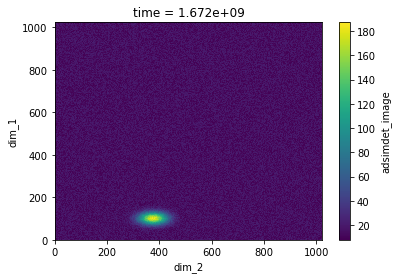

In [7]:

run = cat.v2[uids[0]]
dataset = run.primary.read()
dataset["adsimdet_image"][0][0].plot.pcolormesh()

# Show the image file name on the bluesky (local) workstation
# Use information from the databroker run
_r = run.primary._resources[0]
fname = pathlib.Path(f"{_r['root']}{_r['resource_path']}")
print(f"{fname.exists()=}\n{fname=}")

# confirm the name above () is the same
print(f"{(local_file_name == fname)=}")

In [8]:
run = cat.v2[uids[0]]

local_file_name = AD_full_file_name_local(adsimdet.hdf1)
print(f"{local_file_name.exists()=}\n{local_file_name=}")

rsrc = run.primary._resources[0]
fname = pathlib.Path(f"{rsrc['root']}{rsrc['resource_path']}")
print(f"{fname.exists()=}\n{fname=}")

# confirm they are the same
print(f"{(local_file_name == fname)=}")

# confirm the data is of the expected shape
print(f"{run.primary.read()['adsimdet_image'].shape=}")
assert run.primary.read()["adsimdet_image"].shape == (1, NUM_FRAMES, 1024, 1024)

local_file_name.exists()=True
local_file_name=PosixPath('/tmp/docker_ioc/iocad/tmp/adsimdet/2022/12/22/test_file_0002.h5')
fname.exists()=True
fname=PosixPath('/tmp/docker_ioc/iocad/tmp/adsimdet/2022/12/22/test_file_0002.h5')
(local_file_name == fname)=True
run.primary.read()['adsimdet_image'].shape=(1, 5, 1024, 1024)


## punx

Next, we demonstrate access to the HDF5 image file using the [punx](https://punx.readthedocs.io) program.

In [9]:
from apstools.utils import unix

for line in unix(f"punx tree {local_file_name}"):
    print(line.decode().strip())

!!! WARNING: this program is not ready for distribution.

/tmp/docker_ioc/iocad/tmp/adsimdet/2022/12/22/test_file_0002.h5 : NeXus data file
  entry:NXentry
    @NX_class = "NXentry"
    data:NXdata
      @NX_class = "NXdata"
      data:NX_UINT8[5,1024,1024] = __array
        __array = [
            [
                [9, 16, 8, '...', 21]
                [22, 19, 17, '...', 22]
                [12, 12, 19, '...', 10]
                ...
                [20, 14, 12, '...', 16]
              ]
            [
                [10, 19, 13, '...', 16]
                [14, 9, 22, '...', 20]
                [21, 16, 15, '...', 13]
                ...
                [19, 9, 16, '...', 13]
              ]
            [
                [8, 11, 13, '...', 15]
                [11, 21, 19, '...', 19]
                [22, 10, 8, '...', 8]
                ...
                [14, 21, 19, '...', 16]
              ]
            [
                [15, 17, 8, '...', 18]
                [20, 21, 9, '...', 1